In [73]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

In [74]:
def get_num_cols(df, exclude=None):
    if exclude:
        return df.select_dtypes(include=['number']).columns.drop(exclude)
    else:
        return df.select_dtypes(include=['number']).columns

In [75]:
df = pd.read_csv('..\data\CreditScoring.csv')

In [76]:
df.columns = df.columns.str.lower()

In [77]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

marital_values = {
    1: 'single', 
    2: 'married', 
    3: 'widow', 
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

job_values = {
    1: 'fixed', 
    2: 'partime', 
    3: 'freelance', 
    4: 'others',
    0: 'unk'
}


In [78]:

df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

In [79]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [80]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [81]:
for c in ['income','assets','debt']:
    df[c] = df[c].replace({99999999:np.nan})

In [82]:
df = df[df['status']!='unk'].reset_index(drop=True)

In [83]:
df['status']  = (df['status']=='default').astype(int)

In [84]:
df

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,0,9,rent,60,30,married,no,freelance,73,129.0,0.0,0.0,800,846
1,0,17,rent,60,58,widow,no,fixed,48,131.0,0.0,0.0,1000,1658
2,1,10,owner,36,46,married,yes,freelance,90,200.0,3000.0,0.0,2000,2985
3,0,0,rent,60,24,single,no,fixed,63,182.0,2500.0,0.0,900,1325
4,0,0,rent,36,26,single,no,fixed,46,107.0,0.0,0.0,310,910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4449,1,1,rent,60,39,married,no,fixed,69,92.0,0.0,0.0,900,1020
4450,0,22,owner,60,46,married,no,fixed,60,75.0,3000.0,600.0,950,1263
4451,1,0,owner,24,37,married,no,partime,60,90.0,3500.0,0.0,500,963
4452,0,0,rent,48,23,single,no,freelance,49,140.0,0.0,0.0,550,550


In [85]:
df['status'].value_counts()/len(df)*100

status
0    71.845532
1    28.154468
Name: count, dtype: float64

In [86]:
df['records'] = df['records'].map({"no": 0, "yes": 1})

In [87]:
columns_to_encoding = df.select_dtypes(exclude=['number']).columns
onehot = OneHotEncoder(sparse_output=False)
df_encoding = onehot.fit_transform(df[columns_to_encoding])
df_encoding = pd.DataFrame(df_encoding, columns=onehot.get_feature_names_out(columns_to_encoding))
new_df = pd.concat([df, df_encoding], axis=1).drop(columns=columns_to_encoding, axis=1)

In [88]:
new_df = new_df.dropna()

In [89]:
X = new_df.drop(columns=['status'], axis=1).copy()
y = new_df['status'].copy()

x_train, x_rest, y_train, y_rest = train_test_split(X, y, train_size=0.8, random_state=11, stratify=y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rest, y_rest, test_size=0.5, random_state=11, stratify=y_rest)

print("Train: ", len(x_train))
print("Val: ", len(x_valid))
print("Test: ", len(x_test))

Train:  3501
Val:  438
Test:  438


Escalo los datos

In [90]:
df[get_num_cols(df, exclude=['status','records'])].columns

Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price'],
      dtype='object')

In [91]:
scaler = MinMaxScaler()
x_train_scaled = x_train.copy()
x_valid_scaled = x_valid.copy()

x_train_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']] = scaler.fit_transform(x_train_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']])
x_valid_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']] = scaler.transform(x_valid_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']])

# verificando que siga el mismo tamaño, al parecer si
print(x_train_scaled.shape)

(3501, 28)


In [92]:
x_test_scaled = x_test.copy()

x_test_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']] = scaler.transform(x_test_scaled[['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
        'amount', 'price']])

model

In [93]:
# n_estimators - number of models we want to use
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(x_train_scaled, y_train)

y_pred = rf.predict_proba(x_valid_scaled)[:, 1]
roc_auc_score(y_valid, y_pred)

np.float64(0.8177396762813861)

In [94]:
from sklearn.ensemble import RandomForestClassifier
scores = []

for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(x_train_scaled, y_train)
        
        y_pred = rf.predict_proba(x_valid_scaled)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        scores.append((d, n, auc))

columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores

,max_depth,n_estimators,auc
0,5,10,0.825444
1,5,20,0.824990
2,5,30,0.824108
3,5,40,0.829425
4,5,50,0.827947
5,5,60,0.830826
6,5,70,0.829347
7,5,80,0.830852
8,5,90,0.830048
9,5,100,0.828906


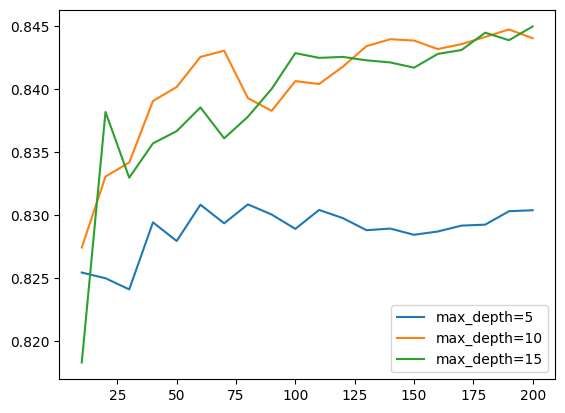

In [95]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
        label='max_depth=%d' % d)
    
plt.legend()

In [96]:
from sklearn.ensemble import RandomForestClassifier
import numpy as n
from sklearn.metrics import roc_auc_score
import pandas as pd
scores = []

for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=10, min_samples_leaf=s, random_state=1)
        rf.fit(x_train_scaled,y_train)
        
        y_pred = rf.predict_proba(x_valid_scaled)[:, 1]
        auc = roc_auc_score(y_valid, y_pred)
        
        scores.append((s, n, auc))

columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [97]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

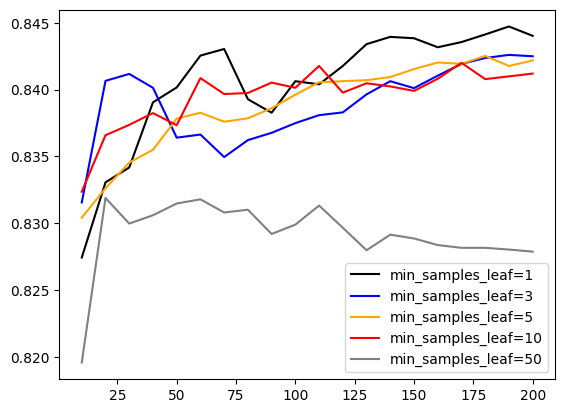

In [98]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf_values = [1, 3, 5, 10, 50]

for s, col in zip(min_samples_leaf_values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
                color=col,
                label='min_samples_leaf=%d' % s)

plt.legend()

In [99]:
rf = RandomForestClassifier(n_estimators=130,
                            max_depth=10,
                            min_samples_leaf=1,
                            random_state=1)
rf.fit(x_train_scaled, y_train)

y_pred = rf.predict_proba(x_valid_scaled)[:, 1]
roc_auc_score(y_valid, y_pred)

np.float64(0.8434063083627308)

In [100]:
precision_score(y_valid, rf.predict(x_valid_scaled))

0.6829268292682927

In [101]:
recall_score(y_valid, rf.predict(x_valid_scaled))

0.45901639344262296

probar con xgboost